In [1]:
# Necessary imports :
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
def get_data(path) -> dict :
    """
    Given the path of the dataset, return
    training and testing images with respective
    labels.
    """
    with h5py.File(path,'r') as F:
        # Names variable contains the names of training and testing file 
        names = list(F.keys())

        data = np.array(F[names[0]][()])
        invXForm = np.array(F[names[1]][()])
        xForm = np.array(F[names[2]][()])
              
    return {'data'    : data,
            'invXForm': invXForm,
            'xForm'   : xForm}


path = 'assign3_data1.h5'
data_h5 = get_data(path)

In [3]:
data = data_h5['data']
invXForm = data_h5['invXForm']
xForm = data_h5['xForm']

In [4]:
print(f'The data has a shape: {data.shape}')

The data has a shape: (10240, 3, 16, 16)


In [5]:
data = np.swapaxes(data,1,3)

In [6]:
print(f'The data has a shape: {data.shape}')

The data has a shape: (10240, 16, 16, 3)


In [7]:
class ImagePreprocessing:
  """
  _____Image preprocessor_____
  
  Functions :
  --- ToGray(data)
      -Takes an input image then converts to gray scale by Luminosity Model

  --- MeanRemoval(data)
      -Extracking the mean of each image themselves

  --- ClipStd(data)
      - Clipping the input image within given condition

  --- Normalize(data,min_scale,max_scale)
      - Normalizing input image to [min_scale,max_scale]

  --- Flatten(data)
      - Flattening input image
  """
  def __init__(self):
    pass
      
  def ToGray(self,data):
    """
    Given the input image converting gray scale according to luminosity model
    """
    R_linear = 0.2126
    G_linear = 0.7152
    B_linear = 0.0722
    gray_data = (data[:,:,:,0] * R_linear) + (data[:,:,:,1] * G_linear) + (data[:,:,:,2] * B_linear)    

    return gray_data 

  def MeanRemoval(self,data):
    """
      Given the input image, substracking the mean of pixel intensity of each image
    """
    axis = (1,2)
    mean_pixel = np.mean(data,axis = axis)
    num_samples = data.shape[0]
    
    # Substracking means of each image seperately :
    for i in range(num_samples):
      data[i] -= mean_pixel[i]
    return data

  def ClipStd(self,data,std_scaler):
    """
    Given the data and range of standart deviation scaler,
    return clipped data
    """
    std_pixel = np.std(data)
    
    min_cond = - std_scaler * std_pixel
    max_cond =   std_scaler * std_pixel

    clipped_data = np.clip(data,min_cond,max_cond)

    return clipped_data

  def Normalize(self,data,min_scale,max_scale):
    """
    Given the data, normalize to given interval [min_val,max_val]
    """
    min = data.max()
    max = data.min()

    # First normalize in [0,1]
    norm_data = (data - min) / (max-min)

    # Normalizing in [min_scale,max_scale]
    range = max_scale - min_scale
    interval_scaled_data = (norm_data * range) + min_scale
    
    return interval_scaled_data

  def Flatten(self,data):
    """
    Given the input image data returning flattened version of the data
    """
    num_samples = data.shape[0]
    flatten  = data.reshape(num_samples,-1)

    return flatten

In [8]:
# Defining preprocessor :
preprocessor = ImagePreprocessing()

In [9]:
# Converting gray scale :
gray_data = preprocessor.ToGray(data = data)

In [10]:
# Mean removing :
mean_removed_data = preprocessor.MeanRemoval(data = gray_data)

In [11]:
# Standart deviation clipping :
clipped_data = preprocessor.ClipStd(data = mean_removed_data,std_scaler = 3)

In [12]:
# Normalized data
data_processed = preprocessor.Normalize(data = clipped_data, min_scale = 0.1, max_scale = 0.9)

In [13]:
print(f' Maximum val of data :  {data_processed.max()}')
print(f' Minimum val of data :  {data_processed.min()}')

 Maximum val of data :  0.9000000357627869
 Minimum val of data :  0.10000000149011612


In [18]:
def plot_patches(data,num_patches, cmap = 'viridis'):
    np.random.seed(15)
    num_samples = data.shape[0]
    random_indexes = np.random.randint(num_samples,size = num_patches)  
    
    plt.figure(figsize = (18,16))
    for i in range(num_patches):
        plt.subplot(20,20,i+1)
        plt.imshow(data[random_indexes[i]],cmap = cmap)
        plt.axis('off')
    plt.show()

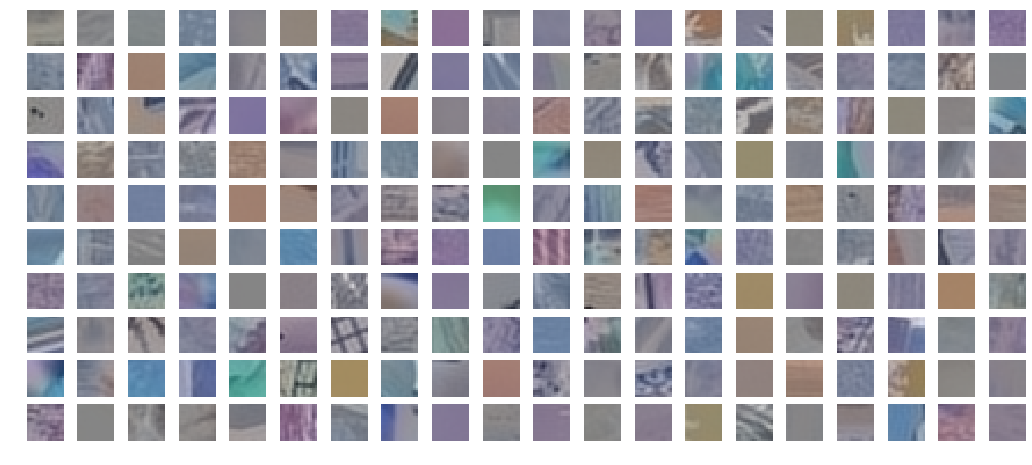

In [19]:
plot_patches(preprocessor.Normalize(data = data, min_scale = 0, max_scale = 1),num_patches = 200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

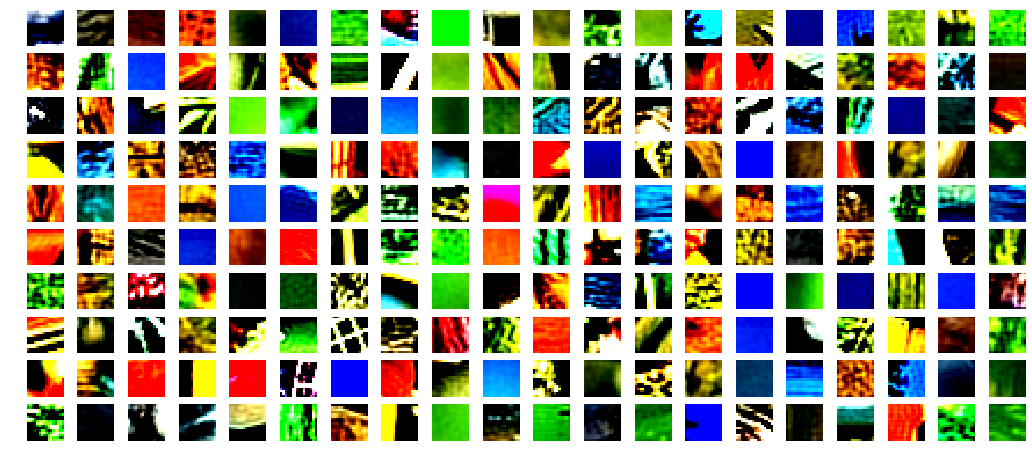

In [22]:
#plot_patches(data,num_patches = 200)

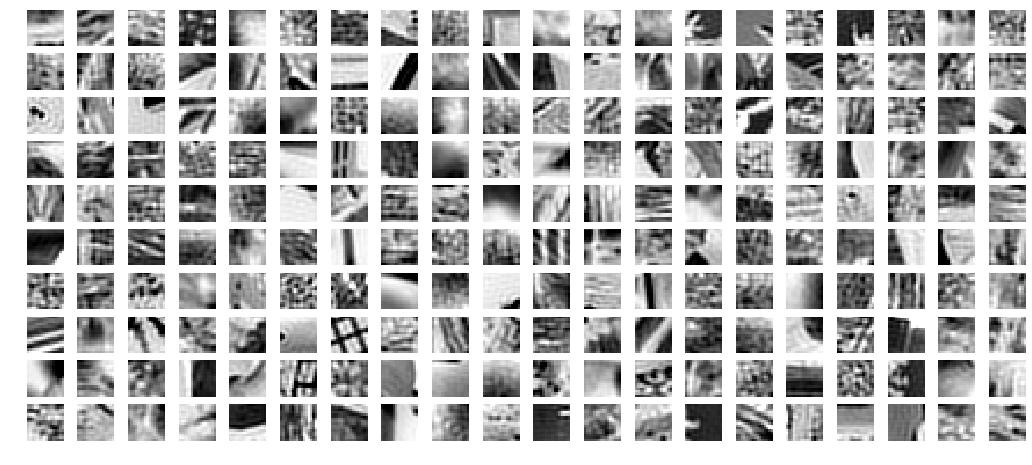

In [21]:
plot_patches(data_processed,num_patches = 200, cmap = 'gray')

In [20]:
class Autoencoder:
    """
    ____Autoencoder____

    Functions :
    --- __init__(input_size,hidden_size)
        - Building overall architecture of the model

    --- InitParams(input_size,hidden_size)
        - Initializing configurable parameters

    --- aeCost(W,data,params)
        - Calculating cost and it's derivatives

    --- Forward(X)
        - Forward pass

    --- Backward(X)
        - Calculation of gradients w.r.t. loss function

    --- KL_divergence()
        - Calculate KL divergence and it's gradients

    --- TykhonowRegulator(X,grad)
        - Computing Tykhonow regularization term and it's gradient

    --- Predict(X)
        - To make predictions

    --- Sigmoid(X, grad)
        - Compute sigmoidal activation and it's gradients

    --- History()
        - To keep track history of the model
    """

    def __init__(self,input_size,hidden_size,lambd): 
        """
        Construction of the architecture of the autoencoder
        """       
        np.random.seed(1500)
        self.lambd = lambd
        self.beta = 1e-1
        self.rho = 5e-2
        self.learning_rate = 9e-1

        self.params = {'L_in'     : input_size,
                       'L_hidden' : hidden_size,
                       'Lambda'   : self.lambd,
                       'Beta'     : self.beta,
                       'Rho'      : self.rho}

        self.W_e = self.InitParams(input_size,hidden_size)
        
        self.loss = []

    def InitParams(self,input_size,hidden_size):
        """
        Given the size of the input node and hidden node, initialize the weights
        drawn from uniform distribution ~ Uniform[- sqrt(6/(L_pre + L_post)) , sqrt(6/(L_pre + L_post))]
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size

        W1_high = self.w_o(input_size,hidden_size)
        W1_low = - W1_high
        W1_size = (input_size,hidden_size)
        self.W1 = np.random.uniform(W1_low,W1_high,size = W1_size)

        B1_size = (1,hidden_size)
        self.B1 = np.random.uniform(W1_low,W1_high,size = B1_size)

        W2_high = self.w_o(hidden_size,self.output_size)
        W2_low = - W2_high
        W2_size = (hidden_size,self.output_size)

        self.W2 = np.random.uniform(W2_low,W2_high,size = W2_size)

        B2_size = (1,self.output_size)
        self.B2 = np.random.uniform(W1_low,W1_high,size = B2_size)
 
        return  {'W1' : self.W1,
                 'W2' : self.W2,
                 'B1' : self.B1,
                 'B2' : self.B2}


    def w_o(self,L_pre,L_post):
        return np.sqrt(6/(L_pre + L_post))


    def sigmoid(self,X, grad = True):
        """
        Computing sigmoid and it's gradient w.r.t. it's input

        """
        sig = 1/(1 + np.exp(-X))

        return sig * (1-sig) if grad else sig

  
    def forward(self,X): 
        """
        Forward propagation
        """      
        W1 = self.W_e['W1'] 
        W2 = self.W_e['W2']
        B1 = self.W_e['B1']
        B2 = self.W_e['B2'] 
        
        Z1 = np.dot(X,W1) + B1         
        A1 = self.sigmoid(Z1,grad = False) 

        Z2 = np.dot(A1,W2) + B2
        A2 = self.sigmoid(Z2,grad = False)
                    
        return {"Z1": Z1,"A1": A1,
                "Z2": Z2,"A2": A2}
    
    def total_loss(self,outs,label):
        W1 = self.W_e['W1']
        W2 = self.W_e['W2']

        Lambda = self.params['Lambda']
        beta = self.params['Beta']
        rho = self.params['Rho']

        J_mse = self.MSE(outs['A2'],label, grad = False)
        J_tykhonow = self.TykhonowRegularization(W1 = W1, W2 = W2,lambd = Lambda, grad = False)
        J_KL = self.KL_divergence(rho = rho,expected = np.mean(outs['A1']), beta = beta, grad = False)

        return J_mse + J_tykhonow + J_KL

    def MSE(self,pred,label, grad = True):
        """
        Calculating Mean Sqaured Error and it's gradient w.r.t. output
        """
        return 1/2 *  (pred - label) if grad else 1/2 * np.sum((pred - label)**2)/pred.shape[0]

    def aeCost(self,data):
        
        outs = self.forward(data)        
        loss = self.total_loss(outs,data)        
        grads = self.backward(outs,data)
        
        return {'J'      : loss,
                'J_grad' : grads}

    def KL_divergence(self,rho,beta,expected,grad = True):
        """
        Computing KL-divergence and it's gradients, note that gradients is only for W1
        """       
        return np.tile(beta * (-(rho/expected) + (1-rho)/(1-expected) ), reps = (10240,1)) if grad else beta * (np.sum((rho * np.log(rho/expected)) + ((1-rho)*np.log((1-rho)/(1-expected)))))

    def TykhonowRegularization(self,W1,W2,lambd,grad = True):
        """
            L2 based regularization computing and it's gradients
        """
        return {'dW1': lambd * W1, 'dW2': lambd * W2} if grad else (lambd/2) * (np.sum(W1**2) + np.sum(W2**2))
       

    def backward(self,outs,data):
        """
        Given the forward pass outputs, input and their labels,
        returning gradients w.r.t. loss functions
        """       
        m = data.shape[0]
        
        Lambda = self.params['Lambda']
        beta = self.params['Beta']
        rho = self.params['Rho']

        W1 = self.W_e['W1'] 
        W2 = self.W_e['W2']
        B1 = self.W_e['B1']
        B2 = self.W_e['B2']

        Z1 = outs['Z1']
        A1 = outs['A1']
        Z2 = outs['Z2']
        A2 = outs['A2']
        
        L2_grad = self.TykhonowRegularization(W1,W2,lambd = Lambda , grad = True)
        KL_grad_W1 = self.KL_divergence(rho,beta,expected = np.mean(A1),grad = True)

        dZ2 = self.MSE(A2,data, grad = True) * self.sigmoid(Z2, grad = True)        
        dW2 = (1/m) * (np.dot(A1.T,dZ2) + L2_grad['dW2'])
        dB2 = (1/m) * (np.sum(dZ2, axis=0, keepdims=True))
        
        dZ1 = (np.dot(dZ2,W2.T) + KL_grad_W1)  * self.sigmoid(Z1,grad = True)        
        dW1 = (1/m) * (np.dot(data.T,dZ1) + L2_grad['dW1'])
        dB1 = (1/m) * (np.sum(dZ1, axis=0, keepdims=True))
       
        assert (dW1.shape == W1.shape and dW2.shape == W2.shape)      

        return {"dW1": dW1, "dW2": dW2,
                "dB1": dB1, "dB2": dB2}   
    
   
    def fit(self,data,epochs = 5000,verbose = True):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
        for epoch in range(epochs):
         
            loss_and_grads = self.aeCost(data)            
            self.step(grads = loss_and_grads['J_grad'])
            
            if verbose:
                print(f"[{epoch}/{epochs}]     ----------> Loss  :{loss_and_grads['J']}")
                
            self.loss.append(loss_and_grads['J'])

    def step(self,grads):
        """
        Updating configurable parameters according to full-batch stochastic gradient update rule
        """       
        self.W_e['W1'] += -self.learning_rate * grads['dW1']
        self.W_e['W2'] += -self.learning_rate * grads['dW2'] 
        self.W_e['B1'] += -self.learning_rate * grads['dB1']                
        self.W_e['B2'] += -self.learning_rate * grads['dB2']
        self.learning_rate *= 0.9999

    
    def evaluate(self):
        plt.plot(self.loss, color = 'orange')
        plt.xlabel(' # of Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss versus Epochs')
        plt.legend([f'Loss : {self.loss[-1]}'])
  
    def display_weights(self):
        """
        Display weights as a image for feature representation
        """
        W1 = self.W_e['W1']
        num_disp = W1.shape[1]
        fig = plt.figure(figsize = (9,8))
        for i in range(num_disp):
            plt.subplot(8,8,i+1)
            plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
            plt.axis('off')
        fig.suptitle('Hidden Layer Feature Representation')    
        plt.show()

    def display_outputs(self,output,data,num = 4):

        """
        Displaying outputs, please give only sqaured values, i.e., 1,4,16,...
        """
        random_indexes = np.random.randint(output.shape[0],size = num)
        plt.figure(figsize=(12, 4))
        for i in range(len(random_indexes)):
            ax = plt.subplot(2,5,i+1)
            plt.imshow(output[random_indexes[i]].reshape(16,16),cmap = 'gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.title("Reconstructed Image")
            #plt.axis('off')
            ax = plt.subplot(2, 5, i + 1 + 5)
            plt.imshow(data[random_indexes[i]].reshape(16,16),cmap = 'gray')
            plt.title("Original Image")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show() 

 
    def parameters(self):
        """
        Returns configurable parameters

        """
        return self.W_e

    def history(self):
        return {'Loss' : self.loss}
                    
               

In [21]:
class Solver:
    """
    Given  as input, A Solver encapsulates all the logic necessary for training then
    implement gradients solver to minimize the cost.The Solver performs stochastic gradient descent.

    """
    def __init__(self, model,data):

        self.model = model
        self.data = data       

    def train(self,epochs = 5000,verbose = False):
        """
        Optimization of the model by minimizing cost by solving gradients
        """
        self.model.fit(self.data,epochs,verbose)

    def parameters(self):
        """
        Returning configurable parameters of the network
        """
        return self.model.parameters()


In [34]:
data_feed = preprocessor.Flatten(data_processed)
input_size = data_feed.shape[1]
hidden_size = 64
autoencoder = Autoencoder(input_size = input_size, hidden_size = hidden_size,lambd = 5e-4)

In [ ]:
solver = Solver(model = autoencoder, data = data_feed)
solver.train(verbose = True)

In [30]:
net_params = solver.parameters()
net_history = autoencoder.history()

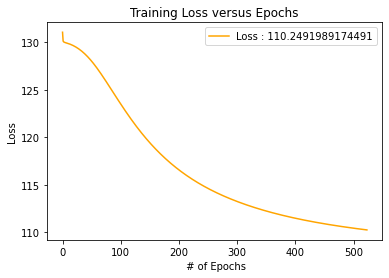

In [31]:
autoencoder.evaluate()

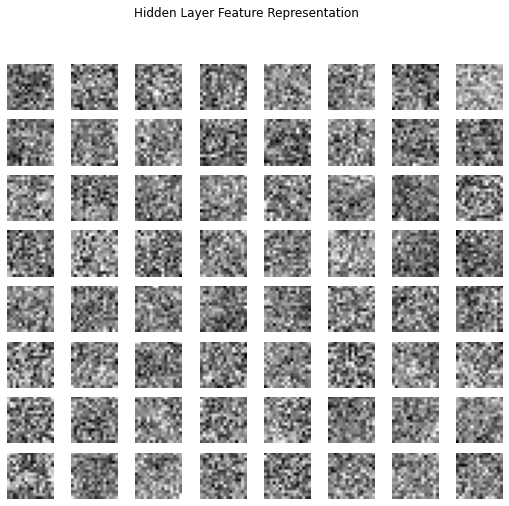

In [32]:
autoencoder.display_weights()

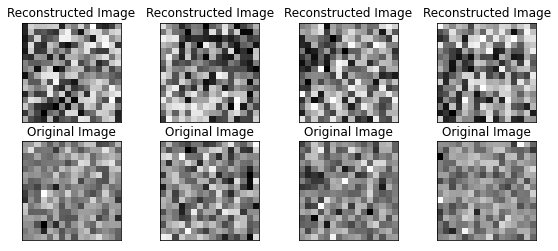

In [33]:
preds = autoencoder.forward(data_feed)
autoencoder.display_outputs(preds['A2'],data_feed)

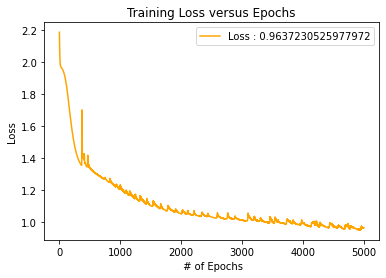

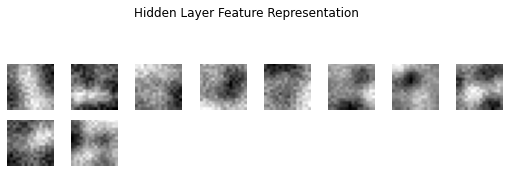

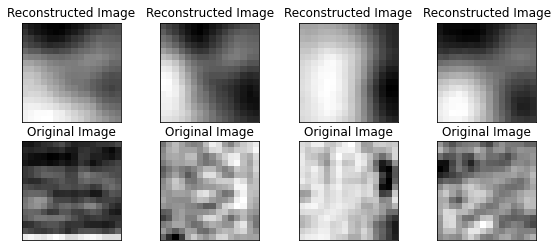

In [113]:
hidden_size_1 = 10
lambd_1 = 0
autoencoder_1 = Autoencoder(input_size = input_size, hidden_size = hidden_size_1, lambd = lambd_1)
solver_1 = Solver(model = autoencoder_1, data = data_feed)
solver_1.train()
autoencoder_1.evaluate()
autoencoder_1.display_weights()
preds_1 = autoencoder_1.forward(data_feed)
autoencoder_1.display_outputs(preds_1['A2'],data_feed)

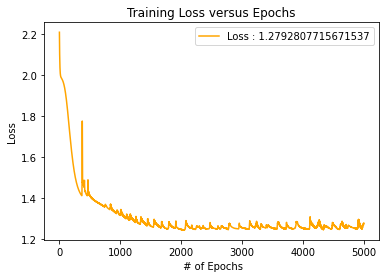

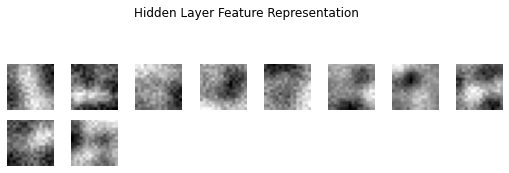

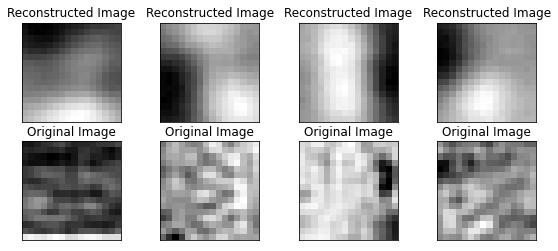

In [114]:
hidden_size_2 = 10
lambd_2 = 1e-3
autoencoder_2 = Autoencoder(input_size = input_size, hidden_size = hidden_size_2, lambd = lambd_2)
solver_2 = Solver(model = autoencoder_2, data = data_feed)
solver_2.train()
autoencoder_2.evaluate()
autoencoder_2.display_weights()
preds_2 = autoencoder_2.forward(data_feed)
autoencoder_2.display_outputs(preds_2['A2'],data_feed)

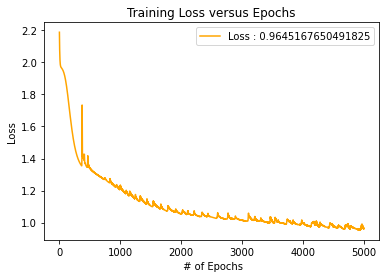

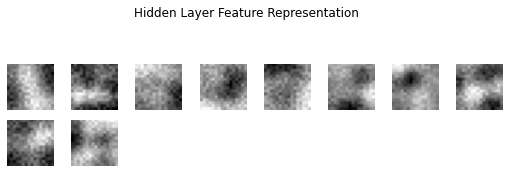

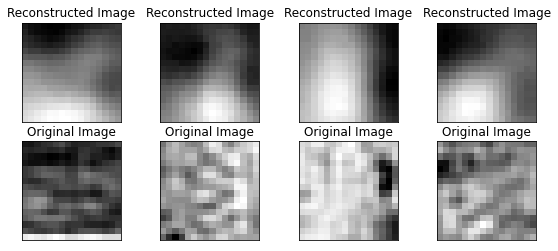

In [115]:
hidden_size_3 = 10
lambd_3 = 1e-5
autoencoder_3 = Autoencoder(input_size = input_size, hidden_size = hidden_size_3, lambd = lambd_3)
solver_3 = Solver(model = autoencoder_3, data = data_feed)
solver_3.train()
autoencoder_3.evaluate()
autoencoder_3.display_weights()
preds_3 = autoencoder_3.forward(data_feed)
autoencoder_3.display_outputs(preds_3['A2'],data_feed)

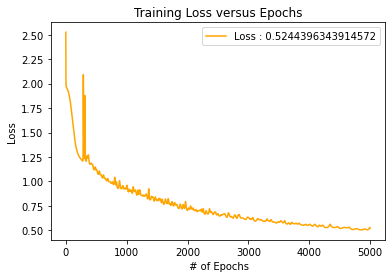

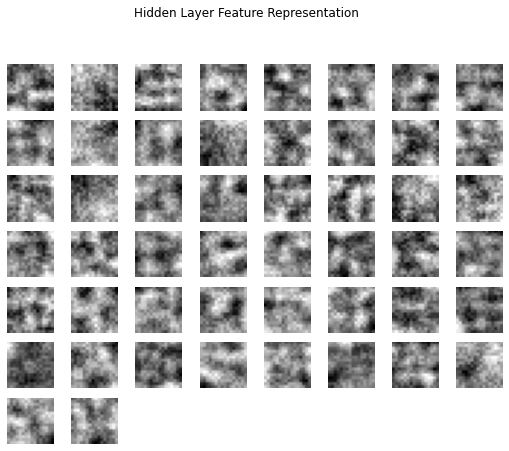

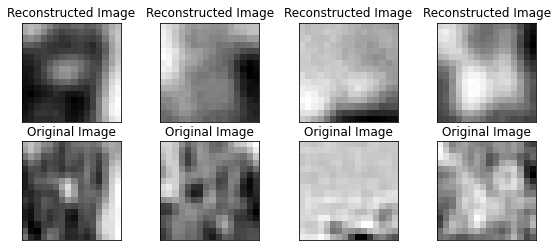

In [116]:
hidden_size_4 = 50
lambd_4 = 0
autoencoder_4 = Autoencoder(input_size = input_size, hidden_size = hidden_size_4, lambd = lambd_4)
solver_4 = Solver(model = autoencoder_4, data = data_feed)
solver_4.train()
autoencoder_4.evaluate()
autoencoder_4.display_weights()
preds_4 = autoencoder_4.forward(data_feed)
autoencoder_4.display_outputs(preds_4['A2'],data_feed)

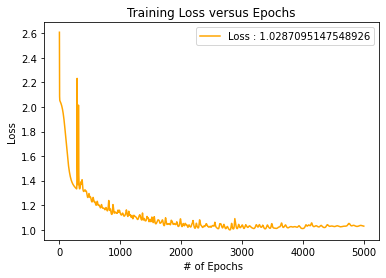

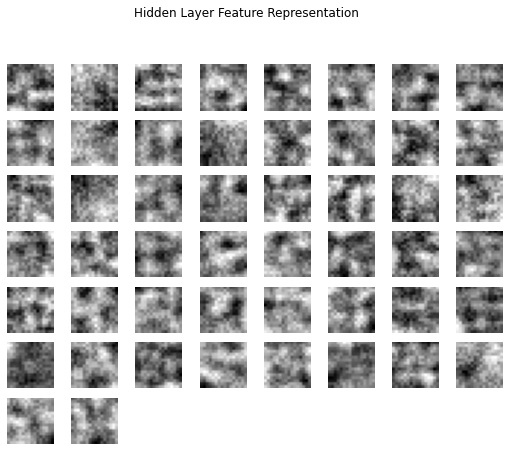

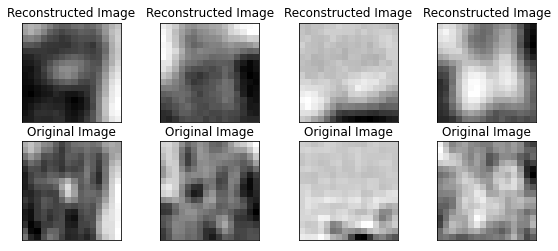

In [117]:
hidden_size_5 = 50
lambd_5 = 1e-3
autoencoder_5 = Autoencoder(input_size = input_size, hidden_size = hidden_size_5, lambd = lambd_5)
solver_5 = Solver(model = autoencoder_5, data = data_feed)
solver_5.train()
autoencoder_5.evaluate()
autoencoder_5.display_weights()
preds_5 = autoencoder_5.forward(data_feed)
autoencoder_5.display_outputs(preds_5['A2'],data_feed)

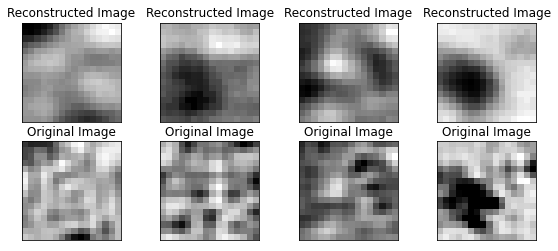

In [122]:
autoencoder_5.display_outputs(preds_5['A2'],data_feed)

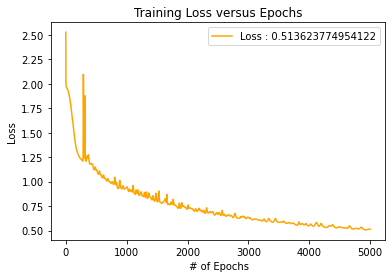

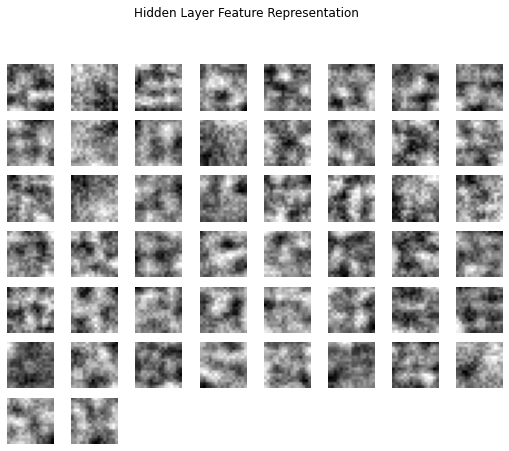

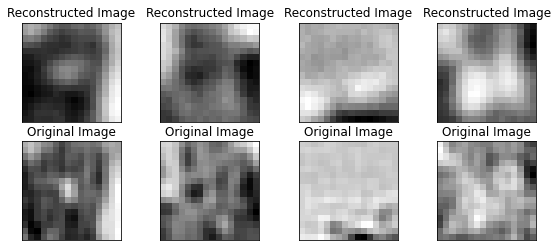

In [118]:
hidden_size_6 = 50
lambd_6 = 1e-5
autoencoder_6 = Autoencoder(input_size = input_size, hidden_size = hidden_size_6, lambd = lambd_6)
solver_6 = Solver(model = autoencoder_6, data = data_feed)
solver_6.train()
autoencoder_6.evaluate()
autoencoder_6.display_weights()
preds_6 = autoencoder_6.forward(data_feed)


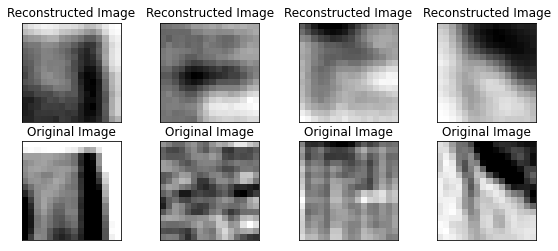

In [121]:
autoencoder_6.display_outputs(preds_6['A2'],data_feed)

In [ ]:
hidden_size_7 = 100
lambd_7 = 0
autoencoder_7 = Autoencoder(input_size = input_size, hidden_size = hidden_size_7, lambd = lambd_7)
solver_7 = Solver(model = autoencoder_7, data = data_feed)
solver_7.train()
autoencoder_7.evaluate()
#autoencoder_7.display_weights()
preds_7 = autoencoder_7.forward(data_feed)
autoencoder_7.display_outputs(preds_7['A2'],data_feed)

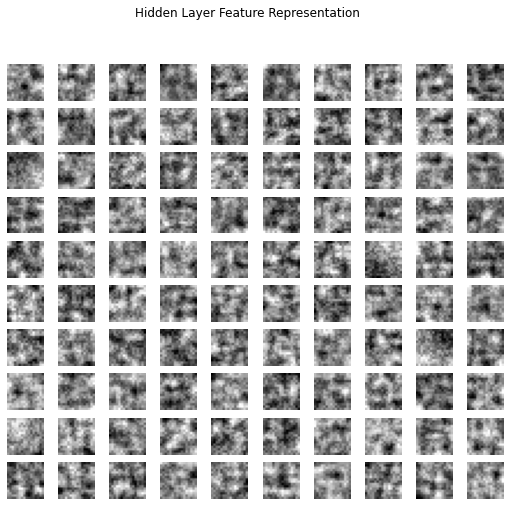

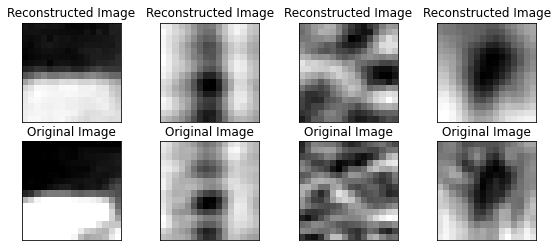

In [123]:
#autoencoder_7.display_weights()
W1 = autoencoder_7.W_e['W1']
num_disp = W1.shape[1]
fig = plt.figure(figsize = (9,8))
for i in range(num_disp):
    plt.subplot(10,10,i+1)
    plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
    plt.axis('off')
fig.suptitle('Hidden Layer Feature Representation')    
plt.show()
preds_7 = autoencoder_7.forward(data_feed)
autoencoder_7.display_outputs(preds_7['A2'],data_feed)

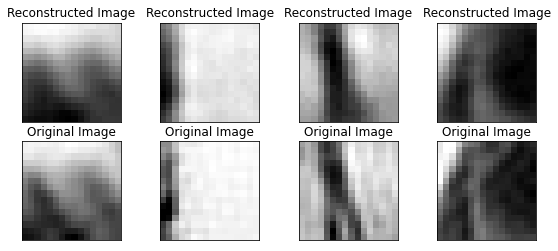

In [162]:
autoencoder_7.display_outputs(preds_7['A2'],data_feed)

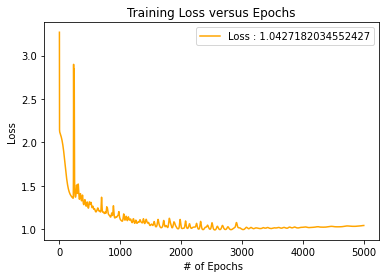

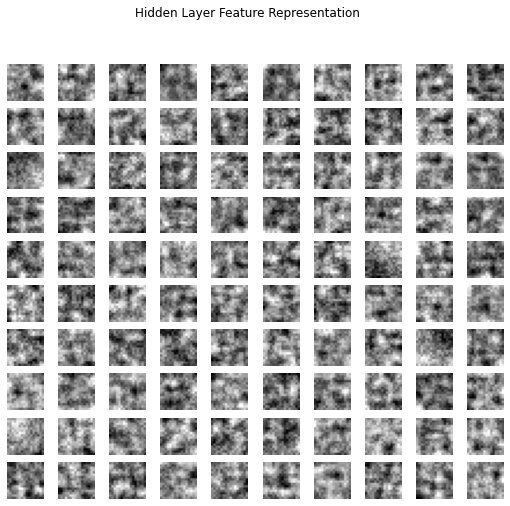

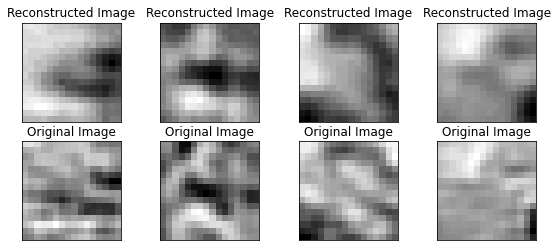

In [124]:
hidden_size_8 = 100
lambd_8 = 1e-3
autoencoder_8 = Autoencoder(input_size = input_size, hidden_size = hidden_size_8, lambd = lambd_8)
solver_8 = Solver(model = autoencoder_8, data = data_feed)
solver_8.train()
autoencoder_8.evaluate()
W1 = autoencoder_8.W_e['W1']
num_disp = W1.shape[1]
fig = plt.figure(figsize = (9,8))
for i in range(num_disp):
    plt.subplot(10,10,i+1)
    plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
    plt.axis('off')
fig.suptitle('Hidden Layer Feature Representation')    
plt.show()
preds_8 = autoencoder_8.forward(data_feed)
autoencoder_8.display_outputs(preds_8['A2'],data_feed)

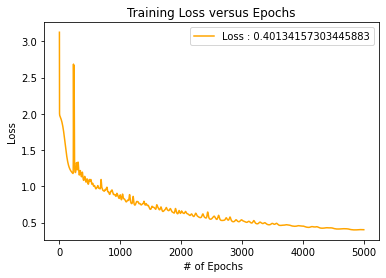

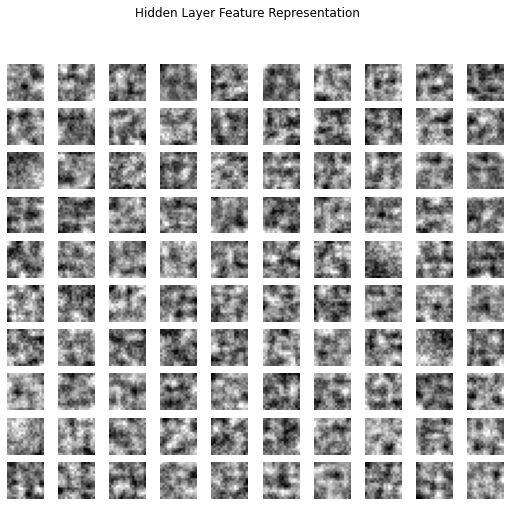

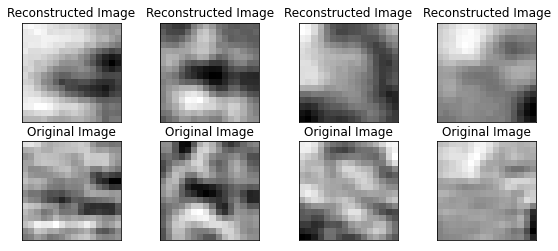

In [126]:
hidden_size_9 = 100
lambd_9 = 1e-5
autoencoder_9 = Autoencoder(input_size = input_size, hidden_size = hidden_size_9, lambd = lambd_9)
solver_9 = Solver(model = autoencoder_9, data = data_feed)
solver_9.train()
autoencoder_9.evaluate()
W1 = autoencoder_9.W_e['W1']
num_disp = W1.shape[1]
fig = plt.figure(figsize = (9,8))
for i in range(num_disp):
    plt.subplot(10,10,i+1)
    plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
    plt.axis('off')
fig.suptitle('Hidden Layer Feature Representation')    
plt.show()
preds_9 = autoencoder_9.forward(data_feed)


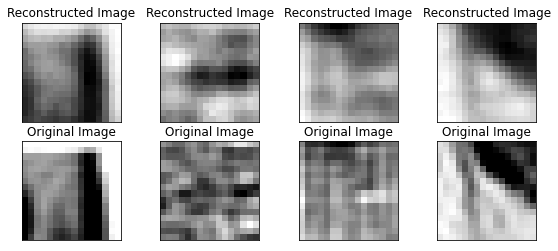

In [127]:
autoencoder_9.display_outputs(preds_9['A2'],data_feed)

In [128]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K

In [129]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("NO GPU, that's okey")

Default GPU Device:/device:GPU:0


In [130]:
def MeanSquaredError():
  def customMeanSquaredError(pred,label):
    return 1/2 * K.sum((pred - label)**2)/pred.shape[0]
  return customMeanSquaredError

def KL_divergence(rho, beta):
  def customKL(out):
    kl1 = rho*K.log(rho/K.mean(out, axis=0))
    kl2 = (1-rho)*K.log((1-rho)/(1-K.mean(out, axis=0)))
    return beta*K.sum(kl1+kl2)
  return customKL


In [170]:
def create_model(hidden_size,lambd):
  tf_weights = tf_weight_initializer(inp_dim = inp_dim, hidden_dim = hidden_size)
  input_img = keras.Input(shape=(inp_dim,))
  encoded = layers.Dense(encoding_dim,activation='sigmoid',
                       kernel_regularizer=tf.keras.regularizers.l2(lambd),
                       activity_regularizer=KL_divergence(rho,beta),
                       kernel_initializer = tf_weights['W1'],
                       bias_initializer = tf_weights['B1'])(input_img)

  decoded = layers.Dense(inp_dim,activation='sigmoid',
                       activity_regularizer=tf.keras.regularizers.l2(lambd),
                       kernel_initializer = tf_weights['W2'],
                       bias_initializer = tf_weights['B2'])(encoded)

  tf_autoencoder = keras.Model(input_img,decoded)
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.9,momentum=0,nesterov=False)
  tf_autoencoder.compile(optimizer=optimizer,loss=MeanSquaredError())                   

  

  return tf_autoencoder

def plot_tf_weights(W1):  
  num_disp = W1.shape[1]
  fig = plt.figure(figsize = (9,8))
  for i in range(num_disp):
      plt.subplot(10,10,i+1)
      plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
      plt.axis('off')
  fig.suptitle('Hidden Layer Feature Representation')    
  plt.show()

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0294
Epoch 2502/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.1046
Epoch 2503/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.1380
Epoch 2504/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0654
Epoch 2505/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0025
Epoch 2506/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.9789
Epoch 2507/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.9741
Epoch 2508/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.9753
Epoch 2509/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.9851
Epoch 2510/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0044
Epoch 2511/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0588
Epoch 2512/5000
1/1 [==============================

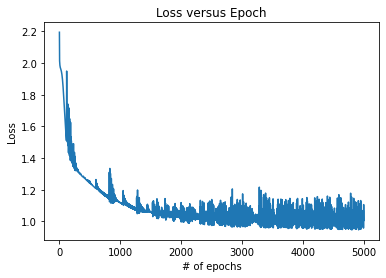

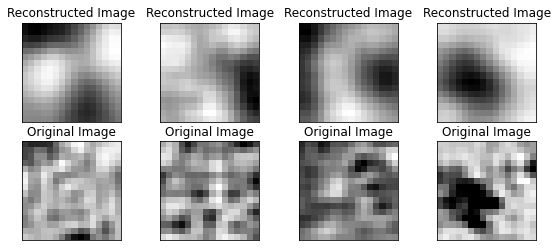

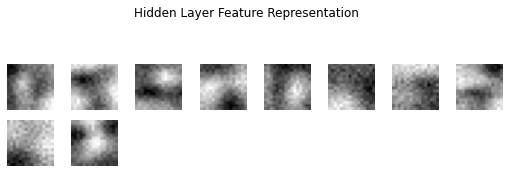

In [134]:
tf_model_1 = create_model(hidden_size = 10,lambd = 0)
tf_model_1.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_1 = tf_model_1.history.history
plt.plot(tf_history_1['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')
plt.legend([f'Loss : {tf_history_1['loss'][-1]}'])

tf_preds_1 = tf_model_1.predict(data_feed)
autoencoder.display_outputs(tf_preds_1,data_feed)
tf_weights_1 = tf_model_1.get_weights()
plot_tf_weights(tf_weights_1[0]) 
  

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.3883
Epoch 2502/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.3288
Epoch 2503/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.2645
Epoch 2504/5000
1/1 [==============================] - 0s 14ms/step - loss: 1.2542
Epoch 2505/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.2786
Epoch 2506/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.2595
Epoch 2507/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.3041
Epoch 2508/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.4769
Epoch 2509/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.5395
Epoch 2510/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.4239
Epoch 2511/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.3484
Epoch 2512/5000
1/1 [=============================

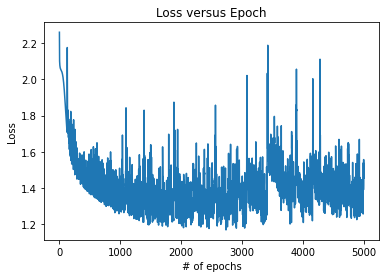

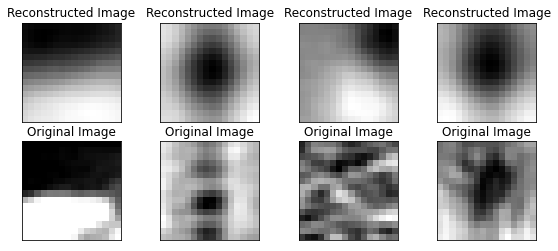

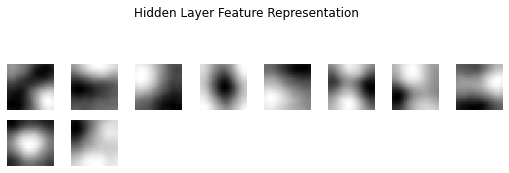

In [135]:
tf_model_2 = create_model(hidden_size = 10,lambd = 1e-3)
tf_model_2.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_2 = tf_model_2.history.history
plt.plot(tf_history_2['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_2 = tf_model_2.predict(data_feed)
autoencoder.display_outputs(tf_preds_2,data_feed)
tf_weights_2 = tf_model_2.get_weights()
plot_tf_weights(tf_weights_2[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0431
Epoch 2502/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0469
Epoch 2503/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0417
Epoch 2504/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0482
Epoch 2505/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0440
Epoch 2506/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0494
Epoch 2507/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0425
Epoch 2508/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0464
Epoch 2509/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0407
Epoch 2510/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0460
Epoch 2511/5000
1/1 [==============================] - 0s 9ms/step - loss: 1.0418
Epoch 2512/5000
1/1 [==============================

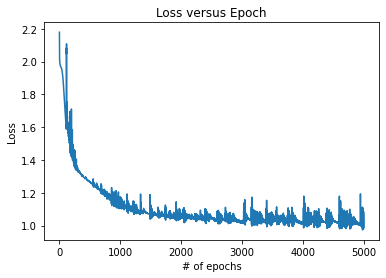

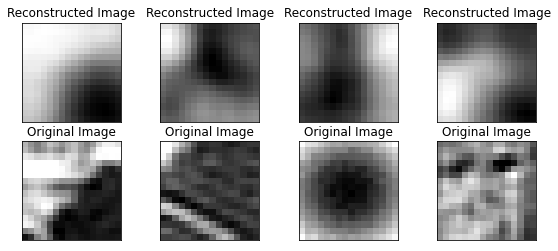

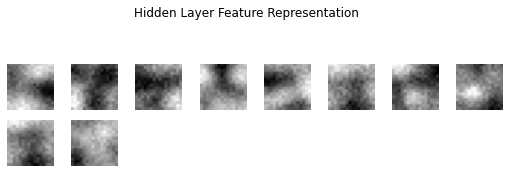

In [136]:
tf_model_3 = create_model(hidden_size = 10,lambd = 1e-5)
tf_model_3.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_3 = tf_model_3.history.history
plt.plot(tf_history_3['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_3 = tf_model_3.predict(data_feed)
autoencoder.display_outputs(tf_preds_3,data_feed)
tf_weights_3 = tf_model_3.get_weights()
plot_tf_weights(tf_weights_3[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.0432
Epoch 2502/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.9983
Epoch 2503/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.9835
Epoch 2504/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.9842
Epoch 2505/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0117
Epoch 2506/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0317
Epoch 2507/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0458
Epoch 2508/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0202
Epoch 2509/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0036
Epoch 2510/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.9899
Epoch 2511/5000
1/1 [==============================] - 0s 11ms/step - loss: 0.9976
Epoch 2512/5000
1/1 [=============================

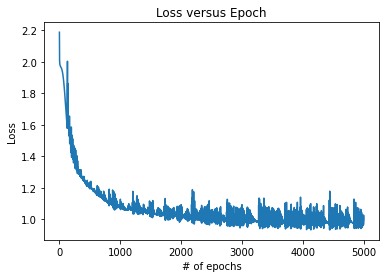

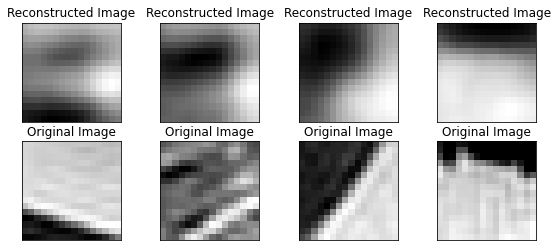

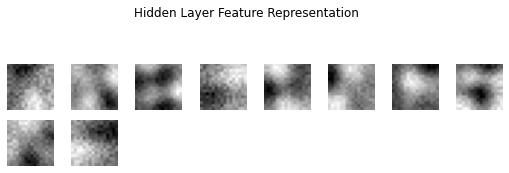

In [137]:
tf_model_4 = create_model(hidden_size = 50,lambd = 0)
tf_model_4.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_4 = tf_model_4.history.history
plt.plot(tf_history_4['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_4 = tf_model_4.predict(data_feed)
autoencoder.display_outputs(tf_preds_4,data_feed)
tf_weights_4 = tf_model_4.get_weights()
plot_tf_weights(tf_weights_4[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.5327
Epoch 2502/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.4963
Epoch 2503/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.4738
Epoch 2504/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.4577
Epoch 2505/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.4840
Epoch 2506/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.4655
Epoch 2507/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.4729
Epoch 2508/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.4649
Epoch 2509/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.4267
Epoch 2510/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.4022
Epoch 2511/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.4468
Epoch 2512/5000
1/1 [=============================

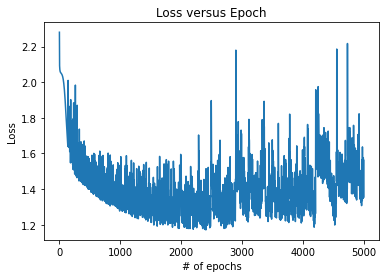

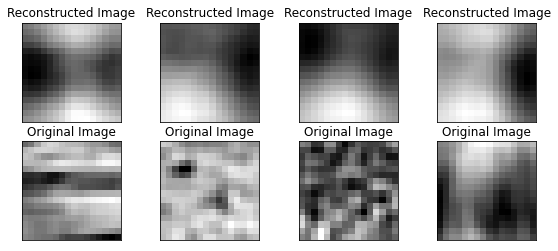

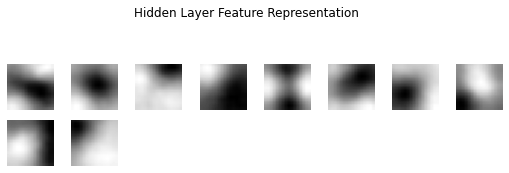

In [138]:
tf_model_5 = create_model(hidden_size = 50,lambd = 1e-3)
tf_model_5.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_5 = tf_model_5.history.history
plt.plot(tf_history_5['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_5 = tf_model_5.predict(data_feed)
autoencoder.display_outputs(tf_preds_5,data_feed)
tf_weights_5 = tf_model_5.get_weights()
plot_tf_weights(tf_weights_5[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0073
Epoch 2502/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0090
Epoch 2503/5000
1/1 [==============================] - 0s 8ms/step - loss: 1.0340
Epoch 2504/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0504
Epoch 2505/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0462
Epoch 2506/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0147
Epoch 2507/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.0044
Epoch 2508/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.9996
Epoch 2509/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.0190
Epoch 2510/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0406
Epoch 2511/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.0551
Epoch 2512/5000
1/1 [==============================

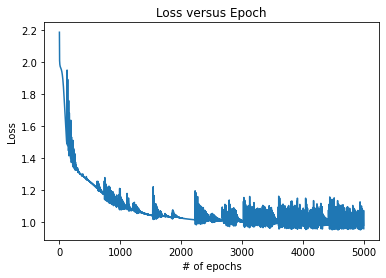

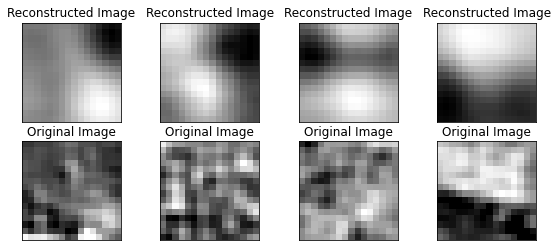

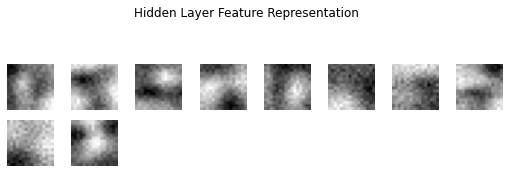

In [139]:
tf_model_6 = create_model(hidden_size = 50,lambd = 1e-5)
tf_model_6.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_6 = tf_model_6.history.history
plt.plot(tf_history_6['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_6 = tf_model_6.predict(data_feed)
autoencoder.display_outputs(tf_preds_6,data_feed)
tf_weights_6 = tf_model_1.get_weights()
plot_tf_weights(tf_weights_6[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0436
Epoch 2502/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0316
Epoch 2503/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0184
Epoch 2504/5000
1/1 [==============================] - 0s 14ms/step - loss: 1.0155
Epoch 2505/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0199
Epoch 2506/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.0317
Epoch 2507/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0434
Epoch 2508/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0573
Epoch 2509/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0456
Epoch 2510/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.0246
Epoch 2511/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0147
Epoch 2512/5000
1/1 [=============================

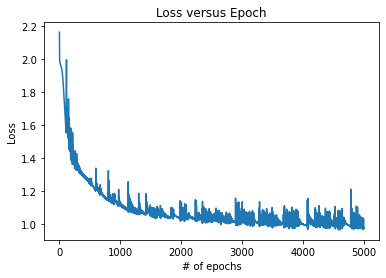

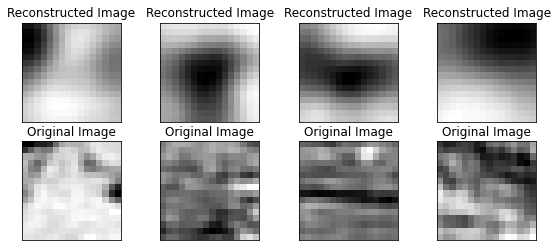

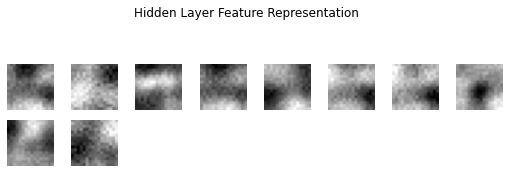

In [140]:
tf_model_7 = create_model(hidden_size = 100,lambd = 0)
tf_model_7.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_7 = tf_model_7.history.history
plt.plot(tf_history_7['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_7 = tf_model_7.predict(data_feed)
autoencoder.display_outputs(tf_preds_7,data_feed)
tf_weights_7 = tf_model_7.get_weights()
plot_tf_weights(tf_weights_7[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.2768
Epoch 2502/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.3192
Epoch 2503/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.2909
Epoch 2504/5000
1/1 [==============================] - 0s 8ms/step - loss: 1.2035
Epoch 2505/5000
1/1 [==============================] - 0s 9ms/step - loss: 1.1636
Epoch 2506/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.2167
Epoch 2507/5000
1/1 [==============================] - 0s 16ms/step - loss: 1.3343
Epoch 2508/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.4451
Epoch 2509/5000
1/1 [==============================] - 0s 12ms/step - loss: 1.4462
Epoch 2510/5000
1/1 [==============================] - 0s 9ms/step - loss: 1.2522
Epoch 2511/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.1922
Epoch 2512/5000
1/1 [============================

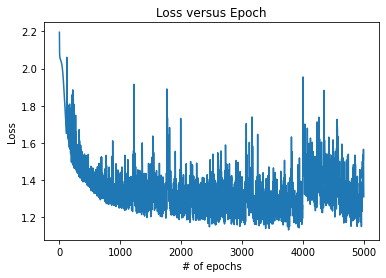

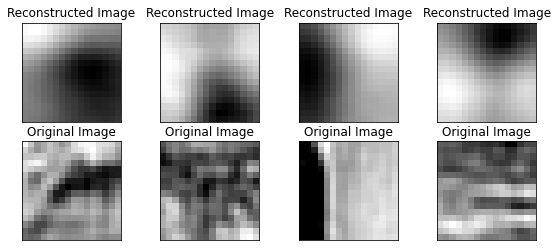

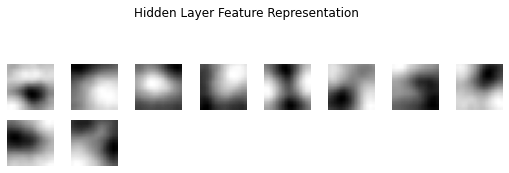

In [141]:
tf_model_8 = create_model(hidden_size = 100,lambd = 1e-3)
tf_model_8.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_8 = tf_model_8.history.history
plt.plot(tf_history_8['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_8 = tf_model_8.predict(data_feed)
autoencoder.display_outputs(tf_preds_8,data_feed)
tf_weights_8 = tf_model_8.get_weights()
plot_tf_weights(tf_weights_8[0]) 

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 7ms/step - loss: 1.0375
Epoch 2502/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0286
Epoch 2503/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0407
Epoch 2504/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0303
Epoch 2505/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0414
Epoch 2506/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0308
Epoch 2507/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0388
Epoch 2508/5000
1/1 [==============================] - 0s 2ms/step - loss: 1.0285
Epoch 2509/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0355
Epoch 2510/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0263
Epoch 2511/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0362
Epoch 2512/5000
1/1 [==============================

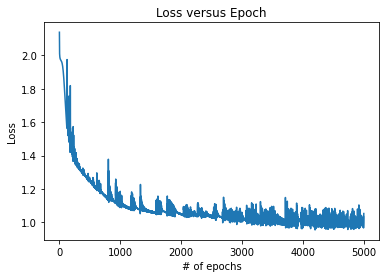

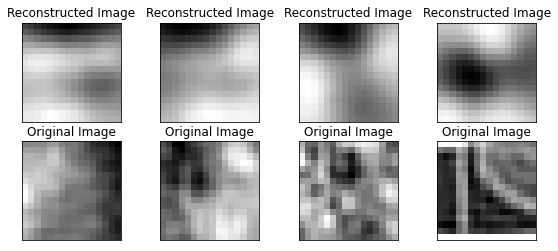

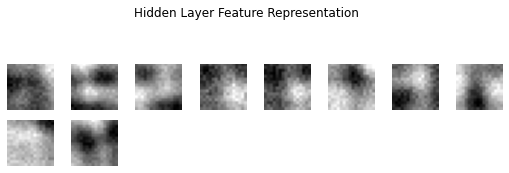

In [142]:
tf_model_9 = create_model(hidden_size = 100,lambd = 1e-5)
tf_model_9.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

tf_history_9 = tf_model_9.history.history
plt.plot(tf_history_9['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

tf_preds_9 = tf_model_9.predict(data_feed)
autoencoder.display_outputs(tf_preds_9,data_feed)
tf_weights_9 = tf_model_9.get_weights()
plot_tf_weights(tf_weights_9[0]) 

In [143]:
#encoding_dim = 10
rho,beta = 5e-1,1e-1
inp_dim = 256
#lamb = 0

W_scaler = lambda L_pre,L_post : np.sqrt(6/(L_pre + L_post))

def tf_weight_initializer(inp_dim,hidden_dim):
  initializer_1 = tf.keras.initializers.RandomUniform(minval=-W_scaler(inp_dim,hidden_dim), maxval=W_scaler(inp_dim,hidden_dim))
  values_2 = initializer_1(shape=(inp_dim,hidden_dim))

  initializer_2 = tf.keras.initializers.RandomUniform(minval=-W_scaler(hidden_dim,inp_dim), maxval=W_scaler(hidden_dim,inp_dim))
  values_2 = initializer_2(shape=(inp_dim,hidden_dim))

  initializer_3 = tf.keras.initializers.RandomUniform(minval=-W_scaler(inp_dim,hidden_dim), maxval=W_scaler(inp_dim,hidden_dim))
  values_3 = initializer_3(shape=(1,hidden_dim))

  initializer_4 = tf.keras.initializers.RandomUniform(minval=-W_scaler(hidden_dim,inp_dim), maxval=W_scaler(hidden_dim,inp_dim))
  values_4 = initializer_4(shape=(1,inp_dim))

  return {'W1':initializer_1,
          'W2':initializer_2,
          'B1':initializer_3,
          'B2':initializer_4}

tf_weights = tf_weight_initializer(inp_dim = inp_dim, hidden_dim = encoding_dim)

In [76]:
input_img = keras.Input(shape=(inp_dim,))

encoded = layers.Dense(encoding_dim,activation='sigmoid',
                       kernel_regularizer=tf.keras.regularizers.l2(lamb),
                       activity_regularizer=KL_divergence(rho,beta),
                       kernel_initializer = tf_weights['W1'],
                       bias_initializer = tf_weights['B1'])(input_img)

decoded = layers.Dense(inp_dim,activation='sigmoid',
                       activity_regularizer=tf.keras.regularizers.l2(lamb),
                       kernel_initializer = tf_weights['W2'],
                       bias_initializer = tf_weights['B2'])(encoded)

tf_autoencoder = keras.Model(input_img,decoded)

In [77]:
tf_autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2816      
Total params: 5,386
Trainable params: 5,386
Non-trainable params: 0
_________________________________________________________________


In [78]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.9,momentum=0,nesterov=False)
tf_autoencoder.compile(optimizer=optimizer,loss=MeanSquaredError())

In [79]:
tf_autoencoder.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0032
Epoch 2502/5000
1/1 [==============================] - 0s 8ms/step - loss: 1.0078
Epoch 2503/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0055
Epoch 2504/5000
1/1 [==============================] - 0s 6ms/step - loss: 1.0219
Epoch 2505/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0150
Epoch 2506/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0298
Epoch 2507/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0173
Epoch 2508/5000
1/1 [==============================] - 0s 4ms/step - loss: 1.0061
Epoch 2509/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0124
Epoch 2510/5000
1/1 [==============================] - 0s 5ms/step - loss: 1.0148
Epoch 2511/5000
1/1 [==============================] - 0s 3ms/step - loss: 1.0296
Epoch 2512/5000
1/1 [==============================

Text(0.5, 1.0, 'Loss versus Epoch')

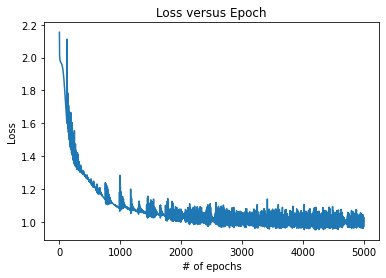

In [84]:
tf_history = tf_autoencoder.history.history
plt.plot(tf_history['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

In [90]:
tf_preds = tf_autoencoder.predict(data_feed)

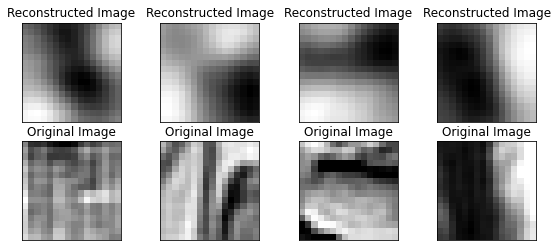

In [91]:
autoencoder.display_outputs(tf_preds,data_feed)

In [92]:
tf_weights = tf_autoencoder.get_weights()

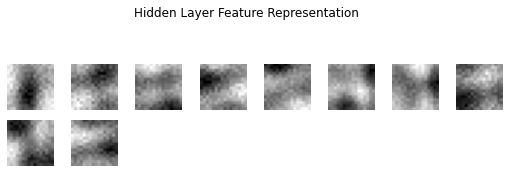

In [95]:
tf_weights = tf_autoencoder.get_weights()
W1 = tf_weights[0]
num_disp = W1.shape[1]
fig = plt.figure(figsize = (9,8))
for i in range(num_disp):
    plt.subplot(8,8,i+1)
    plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
    plt.axis('off')
fig.suptitle('Hidden Layer Feature Representation')    
plt.show()

In [57]:
input_img_optim = keras.Input(shape=(inp_dim,))

encoded_optim = layers.Dense(encoding_dim,activation='sigmoid',
                       kernel_regularizer=tf.keras.regularizers.l2(5e-4),
                       activity_regularizer=KL_divergence(rho,beta))(input_img_optim)

decoded_optim = layers.Dense(inp_dim,activation='sigmoid',
                       activity_regularizer=tf.keras.regularizers.l2(5e-4))(encoded_optim)

tf_autoencoder_optim = keras.Model(input_img_optim,decoded_optim)

tf_autoencoder.compile(optimizer='adam',loss=MeanSquaredError())
tf_autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
Total params: 33,088
Trainable params: 33,088
Non-trainable params: 0
_________________________________________________________________


In [58]:
tf_autoencoder.fit(data_feed, data_feed,
                epochs=5000,
                batch_size=data_feed.shape[0])

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 2501/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.3083
Epoch 2502/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.3083
Epoch 2503/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.3085
Epoch 2504/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.3086
Epoch 2505/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.3085
Epoch 2506/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.3082
Epoch 2507/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.3078
Epoch 2508/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.3077
Epoch 2509/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.3077
Epoch 2510/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.3078
Epoch 2511/5000
1/1 [==============================] - 0s 11ms/step - loss: 0.3079
Epoch 2512/5000
1/1 [=============================

In [172]:
tf_history_optim = tf_autoencoder.history.history
plt.plot(tf_history_optim['loss'],color = 'green')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epoch')

KeyError: ignored

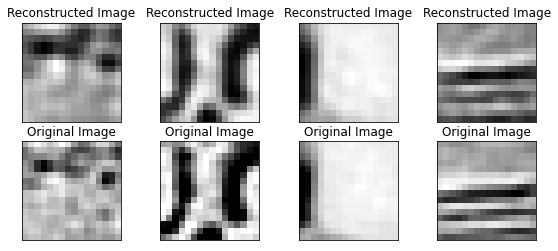

In [66]:
tf_preds_optim = tf_autoencoder.predict(data_feed)
autoencoder.display_outputs(tf_preds_optim,data_feed)

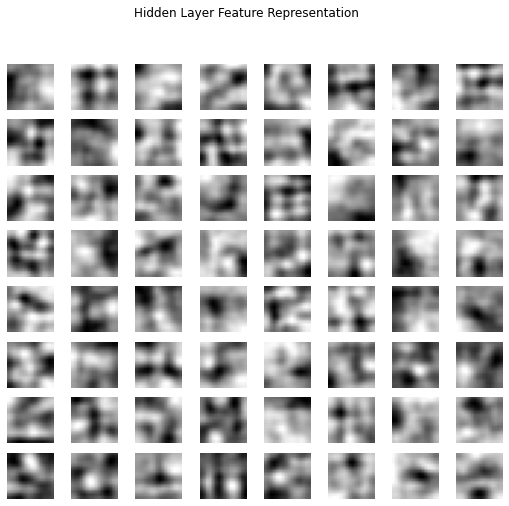

In [67]:
tf_weights_optim = tf_autoencoder_optim.get_weights()
W1 = tf_weights[0]
num_disp = W1.shape[1]
fig = plt.figure(figsize = (9,8))
for i in range(num_disp):
    plt.subplot(8,8,i+1)
    plt.imshow(W1.T[i].reshape(16,16),cmap = 'gray')
    plt.axis('off')
fig.suptitle('Hidden Layer Feature Representation')    
plt.show()